In [1]:
import certifi
from urllib.parse import quote
import urllib3
import json
import numpy as np
from tqdm import tqdm
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt

# Text analysis
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import string
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
"""Get data using the pushshift API for reddit data. 

See https://github.com/pushshift/api for more information on query options and 
http://t-redactyl.io/blog/2015/11/analysing-reddit-data-part-2-extracting-the-data.html
for a nice tutorial using the Reddit API.
"""

'Get data using the pushshift API for reddit data. \n\nSee https://github.com/pushshift/api for more information on query options and \nhttp://t-redactyl.io/blog/2015/11/analysing-reddit-data-part-2-extracting-the-data.html\nfor a nice tutorial using the Reddit API.\n'

In [3]:
def get_data_dict_list(url):
    """Return dictionary of data given query url"""
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',ca_certs=certifi.where())
    data_req = http.request('GET', url.replace(' ','%20')) 
    data = json.loads(data_req.data.decode('utf-8'))['data']
    return data

In [4]:
def posts_df(query_dict, subreddits):
    """Given a dictionary containing parameters for a query to the reddit API and a list of subreddits to search, 
    this function returns a DataFrame with posts relating to the query. 

    The query dictionary should take the form 
    query_dict = {
        'title' : keyword, # keyword must be contained in title
        'before' : '2019-03-02',
        'after' : '2019-02-27',
        'sort' : 'asc',
        'size' : '1000'
    }
    Here, the keywordn(title parameter) is required, but the remaining parameters are optional. 
    An exhaustive list of parameter options can be found at https://github.com/pushshift/api
    The title parameter indicates which keyword must occur in submission titles. 
    subreddits is a list of subreddits to be searched.
    """
    for subreddit in subreddits:
        query_dict['subreddit'] = subreddit

        # Get first 1000 submissions with keyword from subreddit in date range 
        query_string = '&'.join(k + '=' + v for k,v in query_dict.items())
        url = 'https://api.pushshift.io/reddit/search/submission/?' + query_string
        data = get_data_dict_list(url)
        if len(data)>1000: 
            print('More than 1000 submissions in subreddit for date range')
        elif len(data) == 0:
            print(subreddit + ' subreddit contains no posts with keyword ' + keyword + ' in date range.')
           
        return pd.DataFrame(data)

In [5]:
def comments_from_posts_df(data_DF):
    """Return a dataframe with comments for each Reddit post in data_DF."""
    comment_data = [] # to store dictionaries with comment data
    # Get comment ids
    comment_ids = []
    for post_id in tqdm(data_DF[data_DF['num_comments'] > 0]['id']): # Posts with comments
        url = 'https://api.pushshift.io/reddit/submission/comment_ids/' + post_id
        new_ids = get_data_dict_list(url)
        comment_ids.extend(new_ids)

    # Collect comments
    # Need to group into 1000s otherwise it will break
    num_blocks = int(len(comment_ids)/1000)
    if len(comment_ids) % 1000 > 0: num_blocks = num_blocks + 1
    for i in range(num_blocks):
        comment_ids_string = ','.join(comment_ids[i*1000:min((i+1)*1000,len(comment_ids))])
        url = 'https://api.pushshift.io/reddit/comment/search?ids=' + comment_ids_string
        comment_data.extend(get_data_dict_list(url))

    # convert to dataframe and save
    return  pd.DataFrame(comment_data)

# Topic modeling of text from posts relating to hiring during vs before the pandemic.

In [6]:
"""
Get comments for submissions with a specific keyword in the title for various subreddits
"""
keyword = 'hiring' # use quotes for phrases
if ' ' in keyword: keyword = '\"' + keyword + '\"'
    
query_dict = {
    'q' : keyword, 
    'subreddit' : 'jobs',
    'before' : '2020-04-19',
    'after' : '2020-03-15',
    'sort' : 'asc',
    'size' : '1000'
}
post_df_during = posts_df(query_dict, ['jobs'])

query_dict = {
    'q' : keyword, 
    'subreddit' : 'jobs',
    'before' : '2020-02-19',
    'after' : '2020-01-15',
    'sort' : 'asc',
    'size' : '1000'
}
post_df_pre = posts_df(query_dict, ['jobs'])

In [7]:
def apply_nmf(df, data_col_name, num_topics=5, verbose=True, stop_words=None, vectorizer=None):
    tokenizer = TweetTokenizer(preserve_case=False)
    if vectorizer is None:
        ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.001, stop_words=stop_words,
                                           tokenizer=tokenizer.tokenize)
        bag_of_words = ngram_vectorizer.fit_transform(df[data_col_name].values.astype(str)).toarray()
    else:
        bag_of_words = ngram_vectorizer.transform(df[data_col_name].values.astype(str)).toarray()
        
    idx_to_word = np.array(ngram_vectorizer.get_feature_names())
    
    # Apply NMF.
    nmf = NMF(n_components=num_topics) 
    H = nmf.fit_transform(bag_of_words)
    W = nmf.components_
    
    # Print topic keywords.
    if verbose:
        for i, topic in enumerate(W):
            print("Topic {}: {}\n".format(i + 1,[x for x in reversed(idx_to_word[topic.argsort()[-10:]])]))
    return nmf, ngram_vectorizer

In [8]:
# Apply NMF and print topic keywords.

stop_words = stopwords.words('english') + list(string.punctuation) + ['’', '“', '”','#x200b','•','‘', '..']
print("Topics in posts.")
post_nmf, post_ngram_vectorizer = apply_nmf(
    pd.concat([post_df_pre, post_df_during], sort=True), 'selftext', stop_words=stop_words)

Topics in posts.
Topic 1: ['job', 'would', 'company', 'jobs', 'get', 'work', 'time', 'position', 'experience', 'offer']

Topic 2: ['covid', '19', 'covid 19', 'state', 'page', 'state covid', '19 page', 'post', 'resources', 'unemployment']

Topic 3: ['interview', 'would', 'company', 'hiring', 'manager', 'position', 'week', 'email', 'hiring manager', 'back']

Topic 4: ["i'm", 'like', "i've", 'work', 'know', 'really', 'feel', 'job', 'time', 'experience']

Topic 5: ['union', 'get', 'one', 'also', 'months', 'good', 'would', 'work', 'could', 'ship']



We see that a COVID topic occurs in the posts.

In [9]:
def get_topics(vectorizer, df_text_col):
    bag_of_words = post_ngram_vectorizer.transform(df_text_col.values.astype(str)).toarray()
    return post_nmf.transform(bag_of_words)

In [10]:
labels = ['Before Pandemic', 'During Pandemic']
# Mean topic distribution before pandemic.
mean_pre_topics = get_topics(post_ngram_vectorizer, post_df_pre['selftext']).mean(axis=0)
mean_pre_topics /= sum(mean_pre_topics)

mean_during_topics = get_topics(post_ngram_vectorizer, post_df_during['selftext']).mean(axis=0)
mean_during_topics /= sum(mean_during_topics)

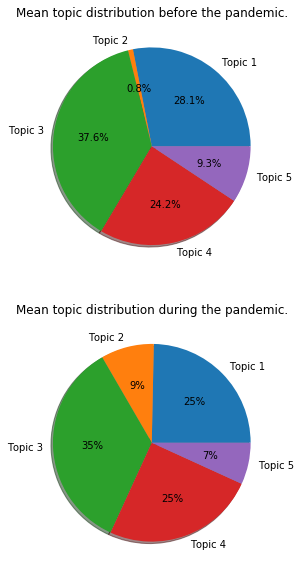

In [11]:
# Pie plots with distributions over topics.

labels = ['Topic {}'.format(i) for i in range(1, len(mean_pre_topics)+1)]
# Make figure and axes.
fig, axs = plt.subplots(2, figsize=[10,10])

axs[0].pie(mean_pre_topics, labels=labels, autopct='%1.1f%%', shadow=True)
axs[0].set_title('Mean topic distribution before the pandemic.')

axs[1].pie(mean_during_topics, labels=labels, autopct='%.0f%%', shadow=True)
axs[1].set_title('Mean topic distribution during the pandemic.')

plt.show()

As expected, the COVID topic emerges during the pandemic. The distributions over the other topics remains similar.

# Sentiment analysis of the "Success and Disappointment Megathread for the Week"

We will be using vaderSentiment since we do not have access to related labeled training data.

In [12]:
def get_sentiment_scores(df_text_col):
    """Return a series with a list of sentiment scores corresponding to ['pos', 'compound', 'neu', 'neg']."""
    df_text_col = df_text_col.dropna()
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = df_text_col.apply(analyzer.polarity_scores)
    sentiment_scores = sentiment_scores.apply(lambda scores: np.array([float(v) for v in scores.values()]))
    return sentiment_scores

In [13]:
"""
Get comments for submissions with a specific keyword in the title for various subreddits
"""
keyword = 'Success and Disappointment Megathread' # use quotes for phrases
if ' ' in keyword: keyword = '\"' + keyword + '\"'
    
    
# Get dataframe with comments from the "Success and Disappointment Megathread for the Week"
query_dict = {
    'q' : keyword, 
    'subreddit' : 'jobs',
    'before' : '2020-04-17',
    'after' : '2020-04-10',
    'sort' : 'asc',
    'size' : '1000'
}
megathread_during = posts_df(query_dict, ['jobs'])
megathread_comment_df_during = comments_from_posts_df(megathread_during)


# Get dataframe with comments from the "Success and Disappointment Megathread for the Week" in 2018
query_dict = {
    'q' : keyword, 
    'subreddit' : 'jobs',
    'before' : '2019-04-17',
    'after' : '2019-04-10',
    'sort' : 'asc',
    'size' : '1000'
}
megathread_df_pre = posts_df(query_dict, ['jobs'])
megathread_comment_df_pre = comments_from_posts_df(megathread_df_pre)

100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


In [14]:
# Get the mean sentiment for the comments in each thread.
pre_sentiments = get_sentiment_scores(megathread_comment_df_pre['body']).mean()
during_sentiments = get_sentiment_scores(megathread_comment_df_during['body']).mean()

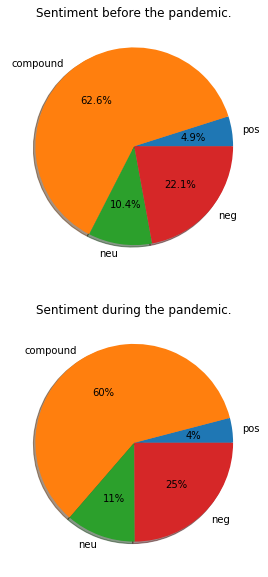

In [15]:
labels = ['pos', 'compound', 'neu', 'neg']
# Make figure and axes
fig, axs = plt.subplots(2, figsize=[10,10])

# A standard pie plot
axs[0].pie(pre_sentiments, labels=labels, autopct='%1.1f%%', shadow=True)
axs[0].set_title('Sentiment before the pandemic.')

# Shift the second slice using explode
axs[1].pie(during_sentiments, labels=labels, autopct='%.0f%%', shadow=True)
axs[1].set_title('Sentiment during the pandemic.')

plt.show()

We can see a small increase in negative sentiment during the pandemic when compared to the same thread before the pandemic.